### 1.Read the Dataset

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
path = '/content/drive/MyDrive/DPF/diabetes.csv'
df = pd.read_csv(path)

### 2.EDA

In [121]:
# Check missing value
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [122]:
# Column Name
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [123]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [125]:
df.shape

(768, 9)

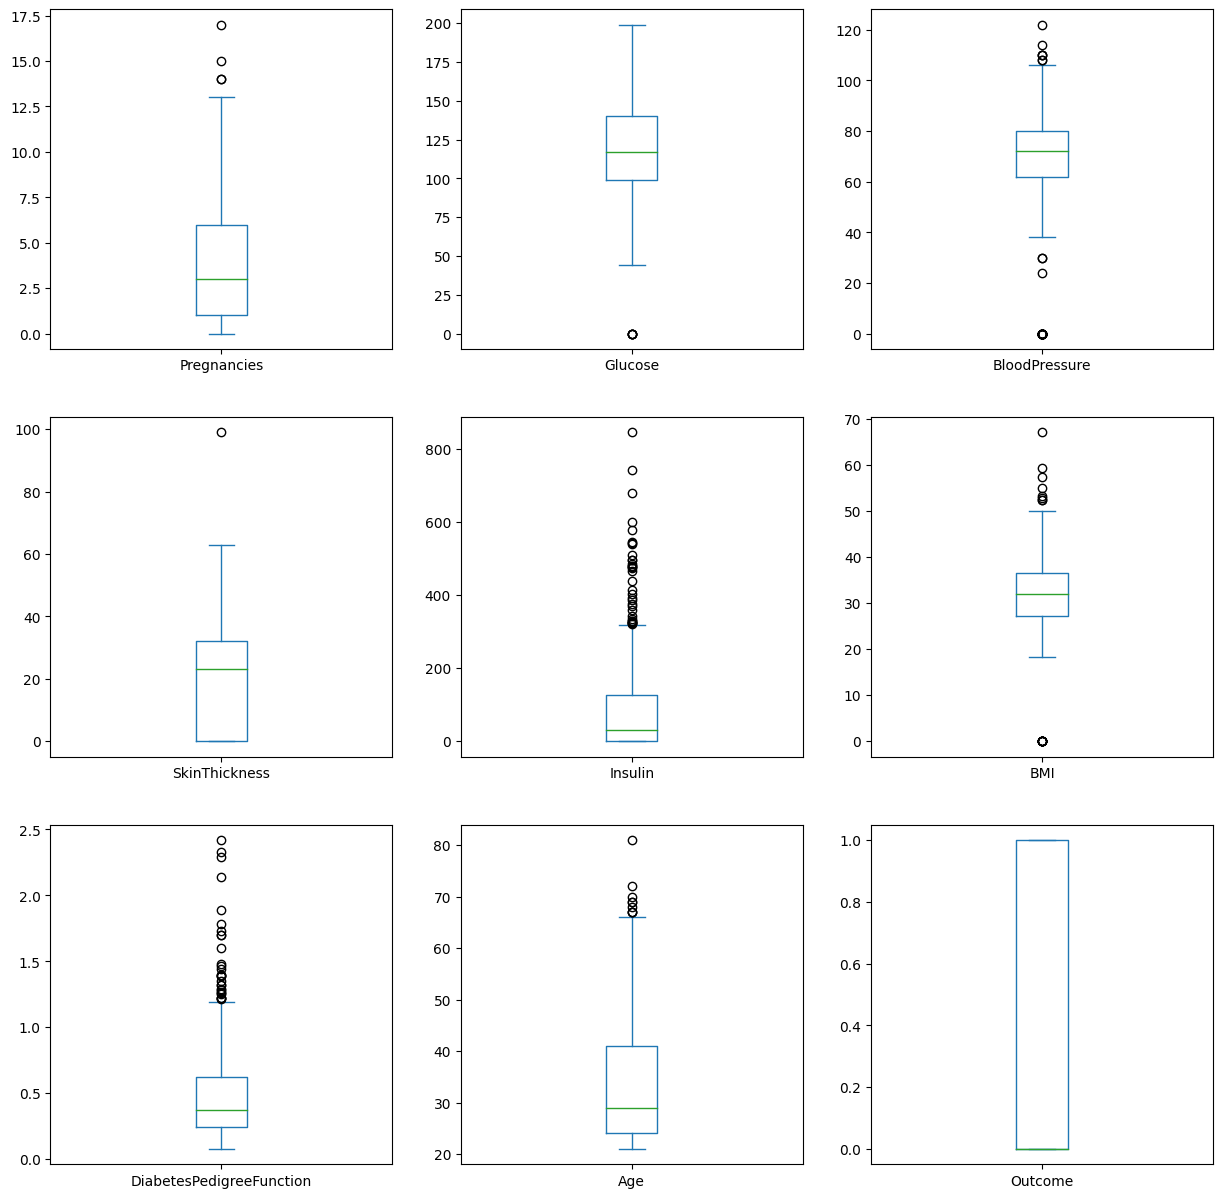

In [126]:
# Box plot for each features
df.plot(kind='box', subplots=True, layout=(3,3), figsize=(15, 15))
plt.show()


In [127]:
#Show the distribustion of Outcome
class_distribution = df['Outcome'].value_counts()
print(class_distribution)

Outcome
0    500
1    268
Name: count, dtype: int64


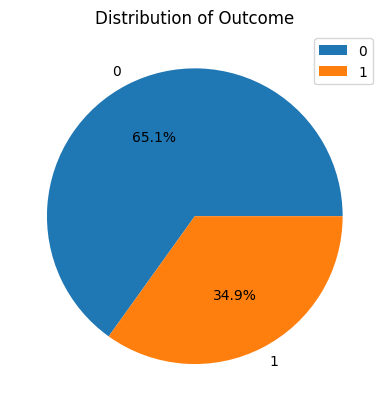

In [128]:
import matplotlib.pyplot as plt
percentages = [100. * x / sum(class_distribution) for x in class_distribution]
plt.pie(class_distribution, autopct='%1.1f%%',labels=['0','1'])
plt.title('Distribution of Outcome')
plt.legend(loc='best')
plt.show()

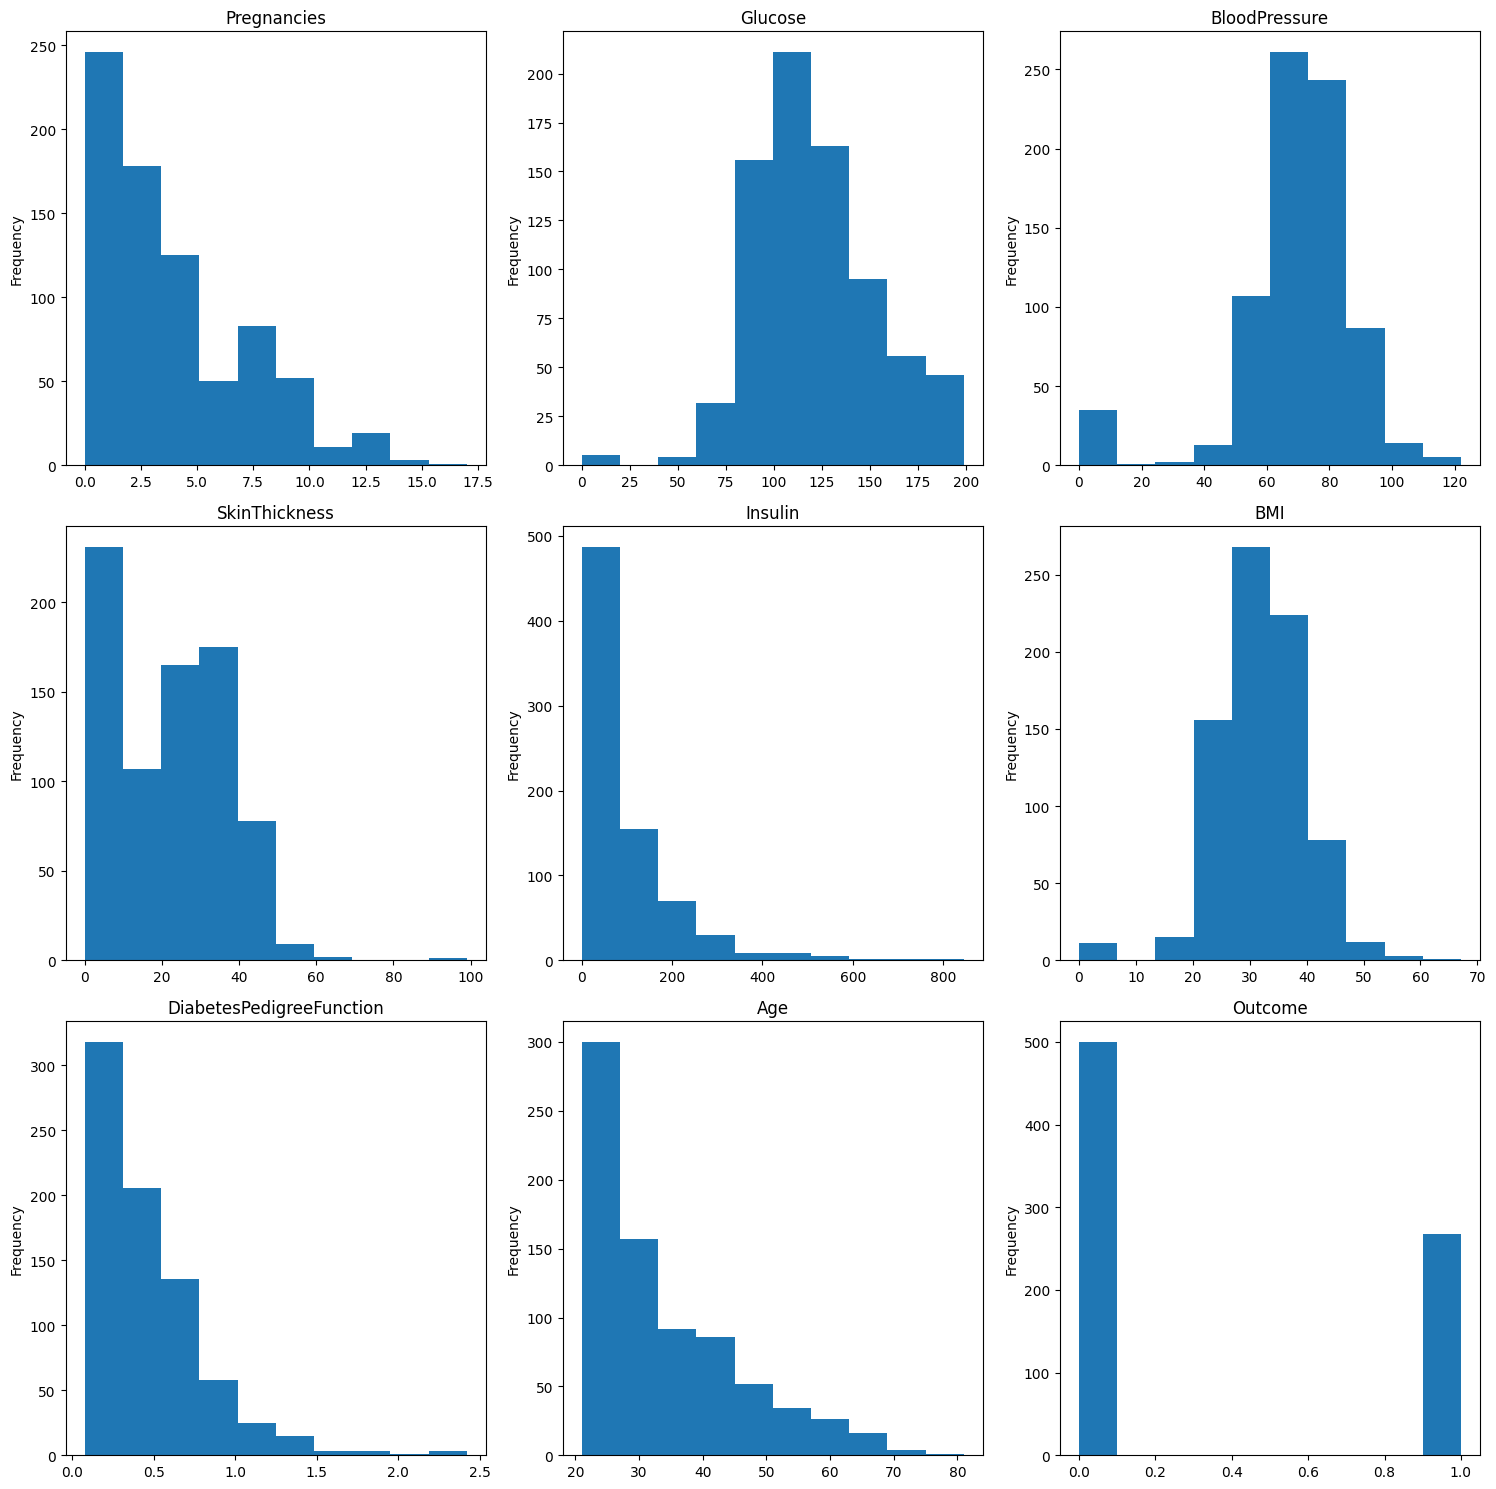

In [129]:
# Make histgram for each features
axes = df.hist(figsize=(15, 15), grid=False)
for ax_row in axes:
    for ax in ax_row:
        ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

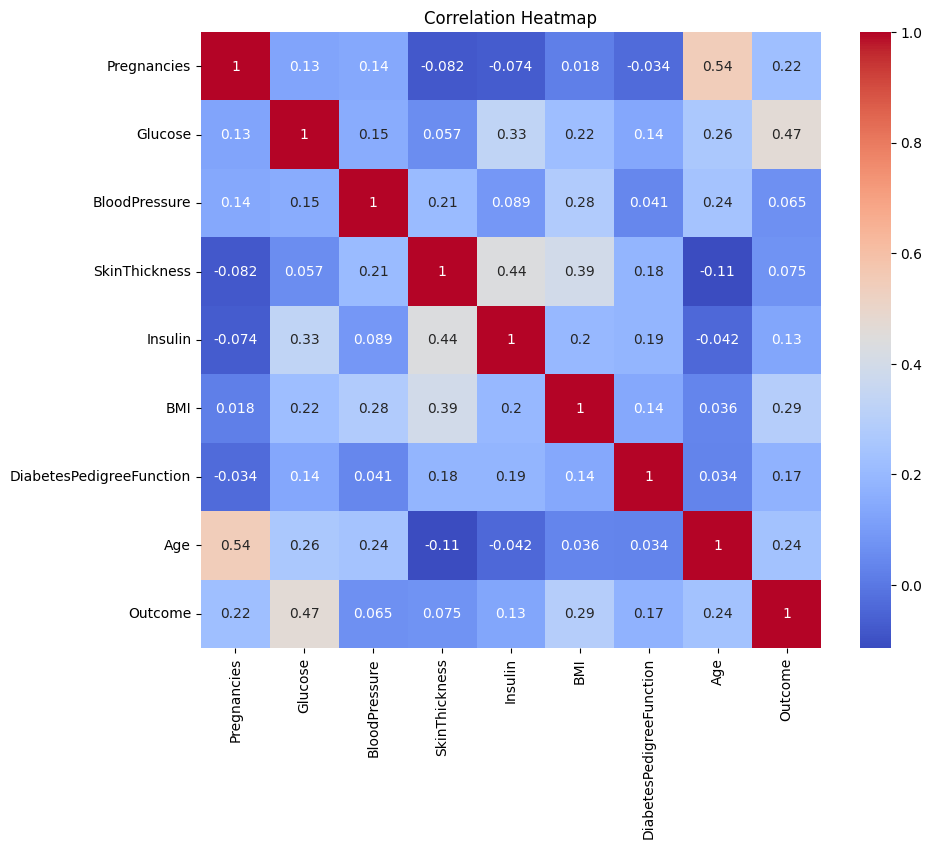

In [130]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### 3.Pre-processing

#### 3.1 Outliers and Zero values

In [131]:
## zero values to NaN
columns_with_zero_as_null = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']
df[columns_with_zero_as_null] = df[columns_with_zero_as_null].replace(0, np.nan)

In [132]:
# Z-score method for Glucose, BloodPressure, SkinThickness, BMI
z_score_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

for col in z_score_columns:
    z_scores = np.abs(stats.zscore(df[col].dropna()))  # Calculate Z-score without NaNs
    z_threshold = 5  # Z-score threshold set to 5
    outliers = z_scores > z_threshold
    df.loc[outliers.index[outliers], col] = np.nan

In [133]:
# IQR method for Pregnancies, Insulin, DiabetesPedigreeFunction, Age
iqr_columns = ['Pregnancies', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

for col in iqr_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 3 * IQR  # Using 3 times IQR for the upper bound
    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = np.nan

#### 3.2 Imputing

In [134]:
imputer = SimpleImputer(strategy='median')
df[:] = imputer.fit_transform(df)

#### 3.3 Standarization

In [135]:
scaler = MinMaxScaler()
df[:] = scaler.fit_transform(df)

### 4.Modeling

#### 4.1 Split the Dataset

In [136]:
X = df.drop(columns='Outcome')
y = df['Outcome']

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 4.2 Baseline Model

In [138]:
from sklearn.dummy import DummyClassifier
naive_baseline = DummyClassifier(strategy="most_frequent")
naive_baseline.fit(X_train, y_train)

y_pred_naive = naive_baseline.predict(X_test)


print("Naive Baseline Model Accuracy:", accuracy_score(y_test, y_pred_naive))
print("Naive Baseline Model Classification Report:\n", classification_report(y_test, y_pred_naive))

Naive Baseline Model Accuracy: 0.6428571428571429
Naive Baseline Model Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78        99
           1       0.00      0.00      0.00        55

    accuracy                           0.64       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.41      0.64      0.50       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### 4.3 Single Layer Perceptron


In [139]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron(max_iter=2, eta0=1.0, random_state=42)
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)

# Evaluate the model
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline Model Classification Report:\n", classification_report(y_test, y_pred))



Baseline Model Accuracy: 0.538961038961039
Baseline Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.28      0.44        99
           1       0.44      1.00      0.61        55

    accuracy                           0.54       154
   macro avg       0.72      0.64      0.52       154
weighted avg       0.80      0.54      0.50       154



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


##### 4.3.1 Max_iteration

Early Stop at: 7
max_iter=50
Accuracy: 0.7077922077922078
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        99
           1       0.57      0.71      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154

Early Stop at: 7
max_iter=100
Accuracy: 0.7077922077922078
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        99
           1       0.57      0.71      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154

Early Stop at: 7
max_iter=200
Accuracy: 0.7077922077922078
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        99
           1       0.57      0.71      0.63        55

    ac

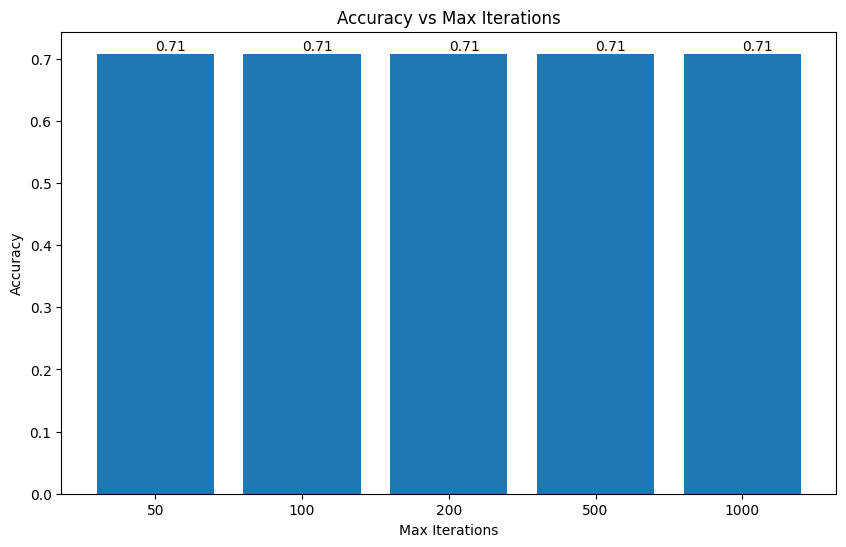

In [140]:
max_iters = [50,100,200,500, 1000]
accuracies = []
for max_iter in max_iters:
  perceptron = Perceptron(max_iter=max_iter, eta0 = 1.0,random_state=42)
  perceptron.fit(X_train, y_train)
  y_pred = perceptron.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)
  print(f"Early Stop at: {perceptron.n_iter_}")
  print(f"max_iter={max_iter}")
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(max_iters)), accuracies, tick_label=max_iters)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.xlabel('Max Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Iterations')
plt.show()



##### 4.3.2 Etas(Learning rate)

Early Stop at: 6
Learning Rate=0.001
Accuracy: 0.6493506493506493
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        99
           1       1.00      0.02      0.04        55

    accuracy                           0.65       154
   macro avg       0.82      0.51      0.41       154
weighted avg       0.77      0.65      0.52       154

Early Stop at: 6
Learning Rate=0.01
Accuracy: 0.6493506493506493
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        99
           1       1.00      0.02      0.04        55

    accuracy                           0.65       154
   macro avg       0.82      0.51      0.41       154
weighted avg       0.77      0.65      0.52       154

Early Stop at: 7
Learning Rate=0.1
Accuracy: 0.7077922077922078
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        99
           1       0.57      0.71      0.6

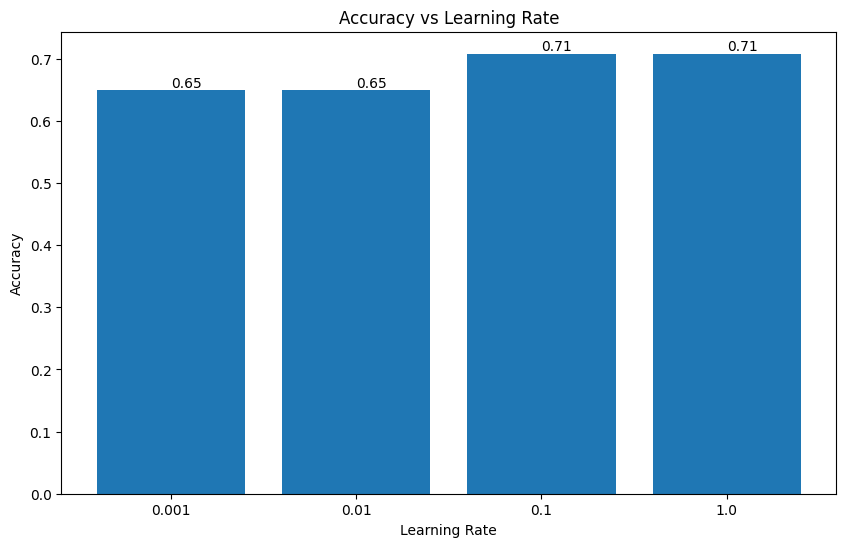

In [141]:
eta0 = [0.001,0.01,0.1,1.0]
accuracies = []

for eta in eta0:
  perceptron = Perceptron(max_iter=1000, eta0 = eta,random_state=42)
  perceptron.fit(X_train, y_train)
  y_pred = perceptron.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)
  print(f"Early Stop at: {perceptron.n_iter_}")
  print(f"Learning Rate={eta}")
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print(classification_report(y_test, y_pred))


plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(eta0)), accuracies, tick_label=eta0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

##### 4.3.3 Regularization

Early Stop at: 7
Regularization=l1
Accuracy: 0.7077922077922078
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        99
           1       0.57      0.71      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154

Early Stop at: 7
Regularization=l2
Accuracy: 0.7077922077922078
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        99
           1       0.57      0.71      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154

Early Stop at: 7
Regularization=ElasticNet
Accuracy: 0.7077922077922078
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        99
           1       0.57      0.71    

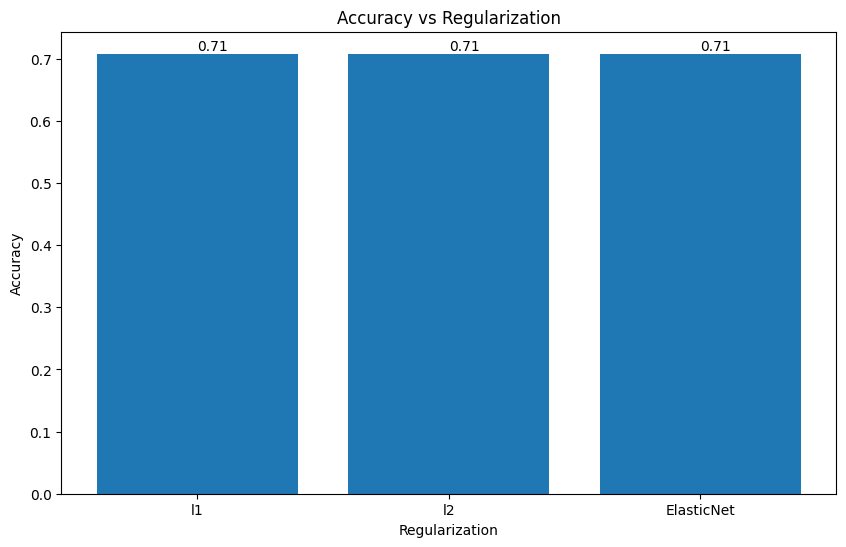

In [142]:
regularizations = ['l1', 'l2','ElasticNet']
accuracies = []

for regularization in regularizations:
  perceptron_l2 = Perceptron(penalty='l2', alpha=0.1, max_iter=1000, random_state=42)
  perceptron_l2.fit(X_train, y_train)
  y_pred = perceptron.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)
  print(f"Early Stop at: {perceptron.n_iter_}")
  print(f"Regularization={regularization}")
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print(classification_report(y_test, y_pred))


plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(regularizations)), accuracies, tick_label=regularizations)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.xlabel('Regularization')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization')
plt.show()

##### 4.3.4 GridSearch

In [143]:
param_grid = {'max_iter': [500, 1000, 2000], 'eta0': [0.001, 0.01, 0.1], 'penalty' : ['l1','l2','ElasticNet']}
grid_search = GridSearchCV(Perceptron(), param_grid, cv=10)
grid_search.fit(X_train, y_train)

best_perceptron = grid_search.best_estimator_

# Evaluation
y_pred_SLP_GridSearch = best_perceptron.predict(X_test)
print(f"Best parameter: {grid_search.best_params_}")
print(f"Accuracy after GridSearch: {accuracy_score(y_test, y_pred_SLP_GridSearch)}")
print(classification_report(y_test, y_pred_SLP_GridSearch))

Best parameter: {'eta0': 0.001, 'max_iter': 500, 'penalty': 'l1'}
Accuracy after GridSearch: 0.6883116883116883
              precision    recall  f1-score   support

           0       0.84      0.64      0.72        99
           1       0.54      0.78      0.64        55

    accuracy                           0.69       154
   macro avg       0.69      0.71      0.68       154
weighted avg       0.73      0.69      0.69       154



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

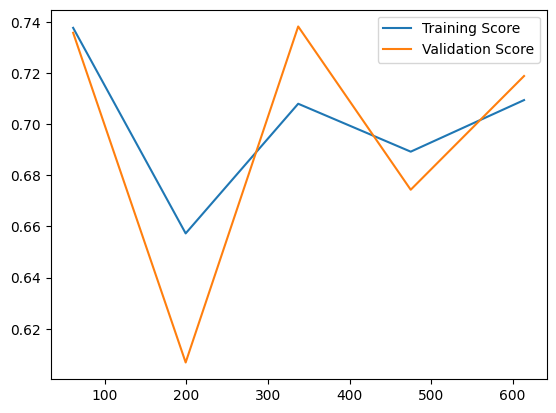

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import Perceptron

# Define the best parameters from GridSearchCV
best_params = {'eta0': 0.001, 'max_iter': 500, 'penalty': 'l1'}

# Initialize the Perceptron model with best parameters
perceptron = Perceptron(eta0=best_params['eta0'], max_iter=best_params['max_iter'], penalty=best_params['penalty'], random_state=42)

train_sizes, train_scores, test_scores = learning_curve(perceptron, X, y, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.legend()
plt.show()

#### 4.4 Other Linear Classifier

Accuracy of Logistic Regression: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        99
           1       0.70      0.60      0.65        55

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154



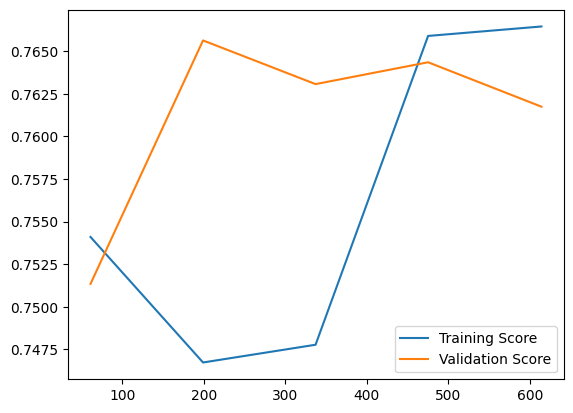

In [150]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Accuracy of Logistic Regression:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

train_sizes, train_scores, test_scores = learning_curve(log_reg, X, y, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.legend()
plt.show()

Accuracy of SVC: 0.7727272727272727
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        99
           1       0.71      0.62      0.66        55

    accuracy                           0.77       154
   macro avg       0.76      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



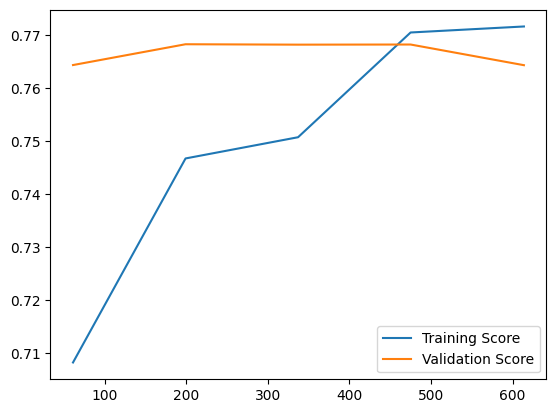

In [151]:
#SVM
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train, y_train)
y_pred_svc_linear = svc_linear.predict(X_test)
print("Accuracy of SVC:", accuracy_score(y_test, y_pred_svc_linear))
print(classification_report(y_test, y_pred_svc_linear))

train_sizes, train_scores, test_scores = learning_curve(svc_linear, X, y, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.legend()
plt.show()

#### 4.5 Activation Function for SLP

In [147]:
from sklearn.neural_network import MLPClassifier
activations = ['logistic', 'tanh', 'relu']
for activation in activations:
    mlp = MLPClassifier(hidden_layer_sizes=(10,), activation=activation, max_iter=1000, random_state=42)
    mlp.fit(X_train, y_train)
    y_pred_mlp = mlp.predict(X_test)
    print(f"Activation Function: {activation} ")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")
    print(classification_report(y_test, y_pred_mlp))

Activation Function: logistic 
Accuracy: 0.7402597402597403
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        99
           1       0.64      0.62      0.63        55

    accuracy                           0.74       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154

Activation Function: tanh 
Accuracy: 0.7532467532467533
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        99
           1       0.66      0.64      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154

Activation Function: relu 
Accuracy: 0.7532467532467533
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        99
           1       0.66      0.64      0.65        55

    accura

#### 4.6 Non-linear Classifier(Random Forest)

Accuracy of Random Forest: 0.7727272727272727
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        99
           1       0.68      0.69      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



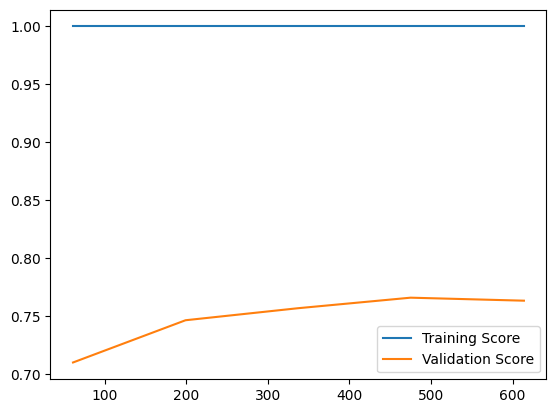

In [152]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)
print("Accuracy of Random Forest:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

train_sizes, train_scores, test_scores = learning_curve(forest, X, y, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.legend()
plt.show()

### 5.Conclusion

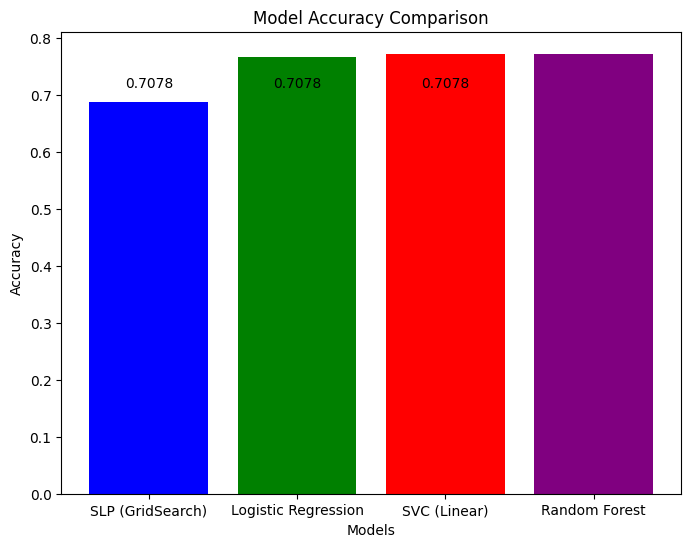

In [154]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

accuracy_SLP = accuracy_score(y_test, y_pred_SLP_GridSearch)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
accuracy_svc_linear = accuracy_score(y_test, y_pred_svc_linear)
accuracy_forest = accuracy_score(y_test, y_pred_forest)

model_names = ['SLP (GridSearch)', 'Logistic Regression', 'SVC (Linear)', 'Random Forest']
accuracies = [accuracy_SLP, accuracy_log_reg, accuracy_svc_linear, accuracy_forest]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])

plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')
plt.show()